<a href="https://colab.research.google.com/github/Rainniee/Neural-Networks-AI/blob/master/Experiment1_RNN%20%26%20GloVe.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [64]:
from __future__ import division
from __future__ import print_function

import pandas as pd
import numpy as np

import itertools
import os

import nltk
from nltk.corpus import stopwords
from sklearn.metrics import confusion_matrix, accuracy_score

from keras.preprocessing.text import Tokenizer
from sklearn.preprocessing import LabelBinarizer, LabelEncoder


%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.python.keras.datasets import imdb
from tensorflow import keras
from keras.layers import Embedding, Flatten, Dense, SimpleRNN, LSTM, Activation, Dropout
from keras.layers import LSTM, CuDNNLSTM

from keras.models import Sequential
from keras.models import load_model
from keras.preprocessing import text, sequence
from keras import utils
from tensorflow.keras.callbacks import EarlyStopping

# This code was tested with TensorFlow v1.4
print("You have TensorFlow version", tf.__version__)

from distutils.version import LooseVersion as LV
from keras import __version__
from keras import backend as K

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

import seaborn as sns
sns.set()

You have TensorFlow version 1.13.1


In [2]:
ls

cleanedfinancial_data.csv  FinanceSentiments.csv  sample_data/


In [3]:
financial_data = pd.read_csv('cleanedfinancial_data.csv')
financial_data.drop(columns="Unnamed: 0", inplace=True)

financial_data.iloc[2,1]

"Well, we need to bring the Shanghai factory online. I think that's the biggest driver for getting to 500K plus a year. Our car is just very expensive going into China. We've got import duties. We've got transport costs. We've got higher-cost labor here. And we've never been eligible for any of the EV tax credits. A lot of people sort of dependent on incentives. In fact, we are [indiscernible] EVs, we have the least access to incentives. It's pretty crazy because there's so many companies that - countries that have put price caps on the EV incentive, which affects Tesla. And in China, which is the biggest market for EVs, we've never had any subsidies or tax incentives for vehicles."

In [4]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer

financial_data.shape[0]

1649

In [5]:
import re
import nltk

nltk.download('punkt')
from nltk.tokenize import word_tokenize as wt 

nltk.download('stopwords')
from nltk.corpus import stopwords

from nltk.stem.porter import PorterStemmer
stemmer = PorterStemmer()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [6]:
financial_data.shape

(1649, 2)

In [0]:
data = []

financial_test = financial_data[financial_data['sentiment'] != 'neutral']

for i in range(financial_test.shape[0]):
    sms = financial_test.iloc[i, 1]

    # remove non alphabatic characters
    sms = re.sub('[^A-Za-z]', ' ', sms)

    # make words lowercase, because Go and go will be considered as two words
    sms = sms.lower()

    # tokenising
    tokenized_sms = wt(sms)

    # remove stop words and stemming
 
    sms_processed = []
    for word in tokenized_sms:
        if word not in set(stopwords.words('english')):
            sms_processed.append(stemmer.stem(word))

    sms_text = " ".join(sms_processed)
    data.append(sms_text)

In [33]:
financial_test['sentiment'] = financial_test['sentiment'].apply(lambda x: 1 if x == 'positive' else 0)

X = tokenizer.texts_to_matrix(financial_test['text'].tolist(), mode='freq')
y = np.asarray(financial_test['sentiment'])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [0]:
# split train and test data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [35]:
# number of most-frequent words to use
nb_words = 10000
# cut texts after this number of words
maxlen = 2000

print('Pad sequences (samples x time)')
x_train = sequence.pad_sequences(X_train, maxlen=maxlen)
x_test = sequence.pad_sequences(X_test, maxlen=maxlen)

print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)

Pad sequences (samples x time)
x_train shape: (648, 2000)
x_test shape: (163, 2000)
y_train shape: (648,)
y_test shape: (163,)


In [36]:
print("First review in the training set:\n", x_train[0], "length:", len(x_train[0]), "class:", y_train[0])

First review in the training set:
 [0 0 0 ... 0 0 0] length: 2000 class: 1


In [37]:
# model parameters:
embedding_dims = 50
lstm_units = 32

print('Build model...')
model = Sequential()

model.add(Embedding(nb_words,
                    embedding_dims,
                    input_length=maxlen))
model.add(Dropout(0.2))

# model.add(LSTM(lstm_units))
# running on a GPU:
model.add(CuDNNLSTM(lstm_units))

# To stack multiple RNN layers, all RNN layers except the last one need
# to have "return_sequences=True".  An example of using two RNN layers:
#model.add(LSTM(lstm_units, return_sequences=True))
#model.add(LSTM(lstm_units))

model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])
print(model.summary())

Build model...
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 2000, 50)          500000    
_________________________________________________________________
dropout_1 (Dropout)          (None, 2000, 50)          0         
_________________________________________________________________
cu_dnnlstm_1 (CuDNNLSTM)     (None, 32)                10752     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 510,785
Trainable params: 510,785
Non-trainable params: 0
_________________________________________________________________
None


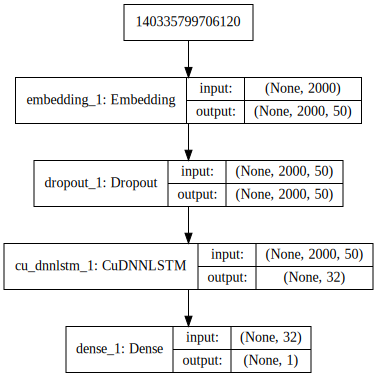

In [38]:
SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

In [39]:
%%time
epochs = 10
validation_split = 0.2

history = model.fit(x_train, y_train, batch_size=128,
          epochs=epochs, 
          validation_split=validation_split)

Instructions for updating:
Use tf.cast instead.
Train on 518 samples, validate on 130 samples
Epoch 1/10
518/518 [==============================] - 6s 11ms/step - loss: 0.6492 - acc: 0.7278 - val_loss: 0.6099 - val_acc: 0.7769
Epoch 2/10
518/518 [==============================] - 1s 2ms/step - loss: 0.5522 - acc: 0.8185 - val_loss: 0.5324 - val_acc: 0.7769
Epoch 3/10
518/518 [==============================] - 1s 2ms/step - loss: 0.4760 - acc: 0.8185 - val_loss: 0.5363 - val_acc: 0.7769
Epoch 4/10
518/518 [==============================] - 1s 2ms/step - loss: 0.4746 - acc: 0.8185 - val_loss: 0.5655 - val_acc: 0.7769
Epoch 5/10
518/518 [==============================] - 1s 2ms/step - loss: 0.4780 - acc: 0.8185 - val_loss: 0.5308 - val_acc: 0.7769
Epoch 6/10
518/518 [==============================] - 1s 2ms/step - loss: 0.4780 - acc: 0.8185 - val_loss: 0.5310 - val_acc: 0.7769
Epoch 7/10
518/518 [==============================] - 1s 2ms/step - loss: 0.4764 - acc: 0.8185 - val_loss: 0.5380

In [40]:
score, acc = model.evaluate(x_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (acc*100))
print("Test score: %.2f%%" % (score*100))

Accuracy: 79.14%
Test score: 51.39%


0.7914110429447853
              precision    recall  f1-score   support

         pos       0.00      0.00      0.00        34
         neg       0.79      1.00      0.88       129

   micro avg       0.79      0.79      0.79       163
   macro avg       0.40      0.50      0.44       163
weighted avg       0.63      0.79      0.70       163

[[  0  34]
 [  0 129]]


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


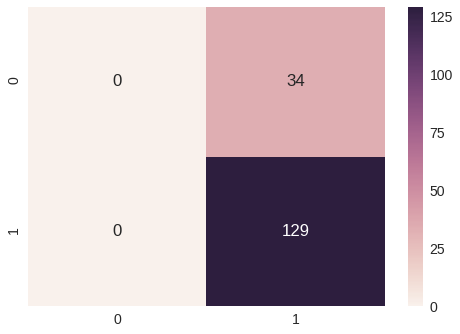

In [41]:
import pandas as pd
import seaborn as sns

from sklearn.metrics import classification_report,confusion_matrix
y_pred = model.predict_classes(np.array(x_test))

from sklearn import metrics
print(metrics.accuracy_score(y_test, y_pred))
target_names = ['pos', 'neg']
cnf_matrix_test = confusion_matrix(y_test, y_pred)

print(classification_report(y_test, y_pred, target_names=target_names))
print(cnf_matrix_test)

df_cm = pd.DataFrame(cnf_matrix_test, range(2), range(2))

sns.set(font_scale=1.4)
sns.heatmap(df_cm, annot=True, fmt='d')

In [42]:
TP = cnf_matrix_test[1, 1]
TN = cnf_matrix_test[0, 0]
FP = cnf_matrix_test[0, 1]
FN = cnf_matrix_test[1, 0]

classification_error = (FP + FN) / float(TP + TN + FP + FN)
print(classification_error)

0.2085889570552147


In [43]:
if not os.path.exists('glove.6B.zip'):
    ! wget http://nlp.stanford.edu/data/glove.6B.zip
if not os.path.exists('glove.6B.50d.txt'):
    ! unzip glove.6B.zip

--2019-03-21 09:29:19--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2019-03-21 09:29:19--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6B.zip        100%[===================>] 822.24M  2.50MB/s    in 6m 52s  

2019-03-21 09:36:12 (1.99 MB/s) - ‘glove.6B.zip’ saved [862182613/862182613]

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


In [48]:
vocab_size = 5000
embedding_size = 50
word_index = imdb.get_word_index()

def load_glove_embeddings(path):
    embeddings = {}
    with open(path, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.strip().split()
            w = values[0]
            vectors = np.asarray(values[1:], dtype='float32')
            embeddings[w] = vectors

    embedding_matrix = np.random.uniform(-1, 1, size=(vocab_size, embedding_size))
    num_loaded = 0
    for w, i in word_index.items():
        v = embeddings.get(w)
        if v is not None and i < vocab_size:
            embedding_matrix[i] = v
            num_loaded += 1
    print('Successfully loaded pretrained embeddings for '
          f'{num_loaded}/{vocab_size} words.')
    embedding_matrix = embedding_matrix.astype(np.float32)
    return embedding_matrix

embedding_matrix = load_glove_embeddings('glove.6B.50d.txt')

1646592/1641221 [==============================] - 0s 0us/step
Successfully loaded pretrained embeddings for 4920/5000 words.


In [0]:
def my_initializer(shape=None, dtype=tf.float32, partition_info=None):
    assert dtype is tf.float32
    return embedding_matrix

params = {'embedding_initializer': my_initializer}

In [0]:
sentence_size = 200
x_len_train = np.array([min(len(x), sentence_size) for x in x_train])
x_len_test = np.array([min(len(x), sentence_size) for x in x_test])

def parser(x, length, y):
    features = {"x": x, "len": length}
    return features, y

def train_input_fn():
    dataset = tf.data.Dataset.from_tensor_slices((x_train, x_len_train, y_train))
    dataset = dataset.shuffle(buffer_size=len(x_train))
    dataset = dataset.batch(100)
    dataset = dataset.map(parser)
    dataset = dataset.repeat()
    iterator = dataset.make_one_shot_iterator()
    return iterator.get_next()

def eval_input_fn():
    dataset = tf.data.Dataset.from_tensor_slices((x_test, x_len_test, y_test))
    dataset = dataset.batch(100)
    dataset = dataset.map(parser)
    iterator = dataset.make_one_shot_iterator()
    return iterator.get_next()

In [58]:
import tempfile
model_dir = tempfile.mkdtemp()

column = tf.feature_column.categorical_column_with_identity('x_train', vocab_size)
classifier = tf.estimator.LinearClassifier(feature_columns=[column], model_dir=os.path.join(model_dir, 'bow_sparse'))

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpfk_swc9j/bow_sparse', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fa24c309e80>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [0]:
all_classifiers = {}
def train_and_evaluate(classifier):
    # Save a reference to the classifier to run predictions later
    all_classifiers[classifier.model_dir] = classifier
    classifier.train(input_fn=train_input_fn, steps=25000)
    eval_results = classifier.evaluate(input_fn=eval_input_fn)
    predictions = np.array([p['logistic'][0] for p in classifier.predict(input_fn=eval_input_fn)])
        
    # Reset the graph to be able to reuse name scopes
    tf.reset_default_graph() 
    # Add a PR summary in addition to the summaries that the classifier writes
    pr = summary_lib.pr_curve('precision_recall', predictions=predictions, labels=y_test.astype(bool), num_thresholds=21)
    with tf.Session() as sess:
        writer = tf.summary.FileWriter(os.path.join(classifier.model_dir, 'eval'), sess.graph)
        writer.add_summary(sess.run(pr), global_step=0)
        writer.close()
#     # Un-comment code to download experiment data from Colaboratory
#     from google.colab import files
#     model_name = os.path.basename(os.path.normpath(classifier.model_dir))
#     ! zip -r {model_name + '.zip'} {classifier.model_dir}
#     files.download(model_name + '.zip')

In [60]:
head = tf.contrib.estimator.binary_classification_head()

def cnn_model_fn(features, labels, mode, params):    
    input_layer = tf.contrib.layers.embed_sequence(
        features['x'], vocab_size, embedding_size,
        initializer=params['embedding_initializer'])
    
    training = mode == tf.estimator.ModeKeys.TRAIN
    dropout_emb = tf.layers.dropout(inputs=input_layer, 
                                    rate=0.2, 
                                    training=training)

    conv = tf.layers.conv1d(
        inputs=dropout_emb,
        filters=32,
        kernel_size=3,
        padding="same",
        activation=tf.nn.relu)
    
    # Global Max Pooling
    pool = tf.reduce_max(input_tensor=conv, axis=1)
    
    hidden = tf.layers.dense(inputs=pool, units=250, activation=tf.nn.relu)
    
    dropout_hidden = tf.layers.dropout(inputs=hidden, 
                                       rate=0.2, 
                                       training=training)
    
    logits = tf.layers.dense(inputs=dropout_hidden, units=1)
    
    # This will be None when predicting
    if labels is not None:
        labels = tf.reshape(labels, [-1, 1])
        

    optimizer = tf.train.AdamOptimizer()
    
    def _train_op_fn(loss):
        return optimizer.minimize(
            loss=loss,
            global_step=tf.train.get_global_step())

    return head.create_estimator_spec(
        features=features,
        labels=labels,
        mode=mode,
        logits=logits, 
        train_op_fn=_train_op_fn)
  
params = {'embedding_initializer': tf.random_uniform_initializer(-1.0, 1.0)}
cnn_classifier = tf.estimator.Estimator(model_fn=cnn_model_fn,
                                        model_dir=os.path.join(model_dir, 'cnn'),
                                        params=params)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpfk_swc9j/cnn', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fa24c2d57b8>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [63]:
def my_initializer(shape=None, dtype=tf.float32, partition_info=None):
    assert dtype is tf.float32
    return embedding_matrix

params = {'embedding_initializer': my_initializer}
cnn_pretrained_classifier = tf.estimator.Estimator(model_fn=cnn_model_fn,
                                        model_dir=os.path.join(model_dir, 'cnn_pretrained'),
                                        params=params)
train_and_evaluate(cnn_pretrained_classifier)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpfk_swc9j/cnn_pretrained', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fa24c32fe48>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.
Instructions for updating:
Use keras.layers.dropout instead.
Instructions for updating:
Use 

NameError: ignored